# CDL Quantum 2021 - Cohort Project 
# Week 1 Challenge: Simulating Quantum Advantage with Trapped Ions
### Team 3: Ziwei Qiu, Oleg Fonarev, Estelle Inack, Yuval  Sanders, Alex Khan

# Introduction
This challenge is simulating and understanding the properties of random quantum circuits, as implemented Google's famous quantum supremacy experiment in 2019. Google's team announced computational superamcy over classical computer by sampling from random circuits composed of 1- and 2-qubit gates on a 54-qubit quantum processor called 'Sycamore'. As the random circuit gets larger and deeper, simulating such a circuit quickly becomes intractable by classical computers. Google's team experimentally passed the threshold at which a quantum process outperforms its classical counterpart. 

The quality of the random circuit simulation is quantified by a single number, Linear Cross-Entropy benchmark $F_{XEB}$, which corresponds to the probability of no error occuring when running the simulation. For a sufficiently deep circuit, this probability distribution converges to the exponential distribution (Porter-Thomas distribution). Intuitively, $F_{XEB}$ is correlated with how often we sample high-probability bitstrings (i.e. probability of probability). A perfect sampling from an ideal circuit without error will achieve $F_{XEB}=1$, while a trivial simulation from a uniform distribution results in $F_{XEB}=0$. The underlying assumption of the quantum supremacy experiment is no classical algorithm can achieve a similar $F_{XEB}$ as the circuit grows sufficiently deep.

# Outline
In the following technical tasks, we first simulate the bit-string probability distributions from an ideal random circuit, as visualized by speckle patterns. The area of each dot represents the probility of measuring that bit-string. Next, we artificially introduced a bit flip error occured at a random qubit at a random location in the circuit. The output states of deep random circuits are expected to be chaotic, so a slight perturbation can lead to very different sampling probabilities. We demonstrate this chaos by visualizing the speckle pattern changes as the bit flip error location varies in the ciruit. In the third task, we demonstrate the probability distribution from an ideal circuit converges to the Porter-Thomas distribution as the circuit is made deeper and deeper. In the last task, we introduce an error on the angle of each 2-qubit gate and illustrates how that affects the resulting $F_{XEB}$ quantity. As shown below, $F_{XEB}$ drops rapidly as the angle error deviates from zero. In addition to the above tasks, we also had a lot fun by generating art from simulating the noisy random circuit (lol). We recognize that the speckle patterns are similar to Pollock paintings and this quantum-assisted art might be of interest to people.



# Environment setup:

Julia Packages required: PastaQ, ITensors (v0.1.41), Plots, and Random

Relevant docs: \
https://github.com/GTorlai/PastaQ.jl \
https://github.com/ITensor/ITensors.jl/blob/v0.1.41/examples/gate_evolution/quantum_simulator.jl

In [6]:
#!/usr/bin/env julia
using PastaQ
using ITensors
using Plots
using Random

The following three functions implement the 1-qubit gate, 2-qubit gate, and the random circuit which outputs a random matrix product state (MPS).

In [279]:
function PastaQ.gate(::GateName"R"; theta::Real, phi::Real)
    [
        cos(theta/2)    (-im * exp(-im * phi) * sin(theta/2))
        (-im * exp(im * phi) * sin(theta/2))     cos(theta/2)
    ]
end

function PastaQ.gate(::GateName"M"; Theta::Real)
    [
        cos(Theta)    0    0    (-im * sin(Theta))
        0    cos(Theta)    (-im * sin(Theta))    0
        0    (-im * sin(Theta))    cos(Theta)    0
        (-im * sin(Theta))    0    0    cos(Theta)
    ]
end

function run(N, depth)
    # Random circuit.
    gates = Vector{Tuple}[]
    
    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand(),))
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end
    
    # returns the value of the last expression evaluated
    psi = runcircuit(N, gates)
end

run (generic function with 1 method)

# Task 1
# Simulating a random circuit with a matrix product state (MPS) code, and producing a speckle pattern.

For a N-qubit circuit, there are $2^N$ possible bit strings, which also represent the eigenstates of qubits in the computational basis. The area of each speckle dot represents the probability of measuring that bit string. We plot the speckle patterns for a few circuits with different number of qubits and circuit depth.

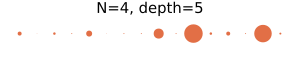

In [282]:
N=4 # Number of qubits
depth = 5 # Depth of the circuit
psi = run(N, depth);

s = siteinds("Qubit", N)
squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]

Plots.scatter([i for i in 1:2^N], zeros(2^N), 
    markersize=squared_mag*40,markercolor	=2,markerstrokecolor=2,
    ylims=(-0.5, 0.5), axis=false, ticks = false, size = (300, 60), legend=false, 
    title = "N=$N, depth=$depth",titlefont=font(10))

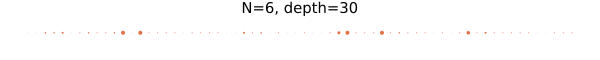

In [285]:
N=6
depth = 30
psi = run(N, depth);

s = siteinds("Qubit", N)
squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]

Plots.scatter([i for i in 1:2^N], zeros(2^N), 
    markersize=squared_mag*40,markercolor	=2,markerstrokecolor=2,
    ylims=(-0.5, 0.5), axis=false, ticks = false, size = (600, 60), legend=false, 
    title = "N=$N, depth=$depth",titlefont=font(10))

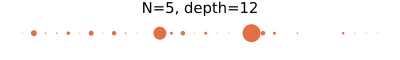

In [287]:
N=5
depth = 12
psi = run(N, depth);

s = siteinds("Qubit", N)
squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]

Plots.scatter([i for i in 1:2^N], zeros(2^N), 
    markersize=squared_mag*50,markercolor	=2,markerstrokecolor=2,
    ylims=(-0.5, 0.5), axis=false, ticks = false, size = (400, 60), legend=false, 
    title = "N=$N, depth=$depth",titlefont=font(10))

# Task 2
## Adding a single bit-flip error and exploring the change in the speckle pattern.
We introduce a bit-flip error to the circuit. The following function implements such a noisy circuit. The two input parameters, `bit_flip_qubit` and `bit_flip_location`, represent which qubit the bit-flip error occurs and its location in the circuit.

In [422]:
function run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location, random_seed = 1234)

    bit_flip_err = ("X", bit_flip_qubit)
    
    Random.seed!(random_seed) # Set the random seed to fix the random circuit 
    
    # Random circuit.
    gates = Vector{Tuple}[]
    count=0 
    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]
        
        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))            
            push!(one_qubit_layer, gate)           
            
            count += 1
            if count == bit_flip_location
                push!(one_qubit_layer, bit_flip_err)  
            end            
            
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand(),))
            push!(two_qubit_layer, gate)
            count += 1
            if count == bit_flip_location
                push!(one_qubit_layer, bit_flip_err)  
            end
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end
    
    # returns the value of the last expression evaluated
    psi = runcircuit(N, gates)
#     return psi, bit_flip_qubit, bit_flip_location
end

run_with_bit_flip_error (generic function with 4 methods)

### Bit-flip error on a random qubit at a random location
`bit_flip_qubit` and `bit_flip_location` are randomly generated numbers. As seen below, a single bit-flip error causes drastic changes in the probability distribution visualized by the speckle patterns.

`bit_flip_qubit`=i means the bit-flip error occurs on the i-th qubit.\
`err_location`=j means the bit-flip error occurs right after the j-th gates.


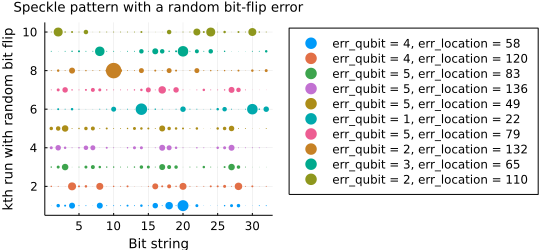

In [277]:
N=5
depth = 20
s = siteinds("Qubit", N)
max_k = 10

# choose a random location among all operations  
bit_flip_qubit_list = [rand(1:N) for i in 1:max_k];
bit_flip_location_list = [rand(1: floor(Int, N*depth + depth/2*(N-1))) for i in 1:max_k];

k=1
bit_flip_qubit = bit_flip_qubit_list[k]
bit_flip_location = bit_flip_location_list[k]
psi= run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location);
squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
Plots.scatter([j for j in 1:2^N], ones(2^N)*k, 
    markersize=squared_mag*40,markercolor	=k,markerstrokecolor=k,
    ylims=(0.5, 1.5), axis=true, ticks = true, size = (500, 800), 
    legend=true, label = "err_qubit = $bit_flip_qubit, err_location = $bit_flip_location", )

for k in 2:max_k
    bit_flip_qubit = bit_flip_qubit_list[k]
    bit_flip_location = bit_flip_location_list[k]
    
    psi = run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location);
    squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
       
    Plots.scatter!([j for j in 1:2^N], ones(2^N)*k, 
        markersize=squared_mag*40,markercolor=k,markerstrokecolor=k,
        ylims=(0.5, max_k+0.5), axis=true, ticks = true, size = (550, 25*max_k), guidefont=font(9),
        label = "err_qubit = $bit_flip_qubit, err_location = $bit_flip_location", legend=:outerright,
        title="Speckle pattern with a random bit-flip error", titlefont=font(9))
end

ylabel!("kth run with random bit flip")
xlabel!("Bit string")
current()

### Bit-flip error on a fixed qubit at different locations
To get a better understanding of this perturbation, we fix the error qubit and vary the location of this error. We visualize how the speckle pattern evolves as the error moves in the circuit. We observe that the speckle patterns are likely correlated among the circuits where the error locations are very close to each other.



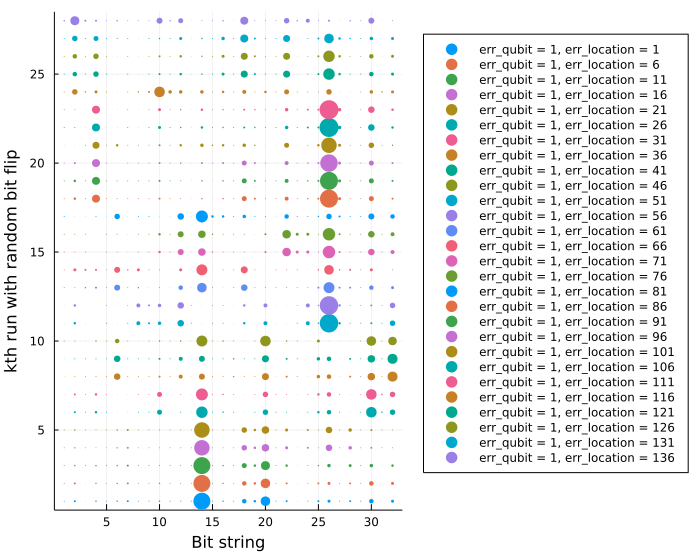

In [278]:
N=5
depth = 20
s = siteinds("Qubit", N)

# choose a random location among all operations  
bit_flip_location_list = [i for i in 1:5:floor(Int, N*depth + depth/2*(N-1))];
max_k = length(bit_flip_location_list);
bit_flip_qubit_list = [1 for i in 1:max_k];

k=1
bit_flip_qubit = bit_flip_qubit_list[k]
bit_flip_location = bit_flip_location_list[k]
psi= run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location);
squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
Plots.scatter([j for j in 1:2^N], ones(2^N)*k, 
    markersize=squared_mag*40,markercolor	=k,markerstrokecolor=k,
    ylims=(0.5, 1.5), axis=true, ticks = true, size = (500, 800), 
    legend=true, label = "err_qubit = $bit_flip_qubit, err_location = $bit_flip_location", )

for k in 2:max_k
    bit_flip_qubit = bit_flip_qubit_list[k]
    bit_flip_location = bit_flip_location_list[k]
    
    psi = run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location);
    squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
       
    Plots.scatter!([j for j in 1:2^N], ones(2^N)*k, 
        markersize=squared_mag*40,markercolor=k,markerstrokecolor=k,
        ylims=(0.5, max_k+0.5), axis=true, ticks = true, size = (700, 20*max_k), 
        label = "err_qubit = $bit_flip_qubit, err_location = $bit_flip_location", legend=:outerright)
end

ylabel!("kth run with random bit flip")
xlabel!("Bit string")
current()

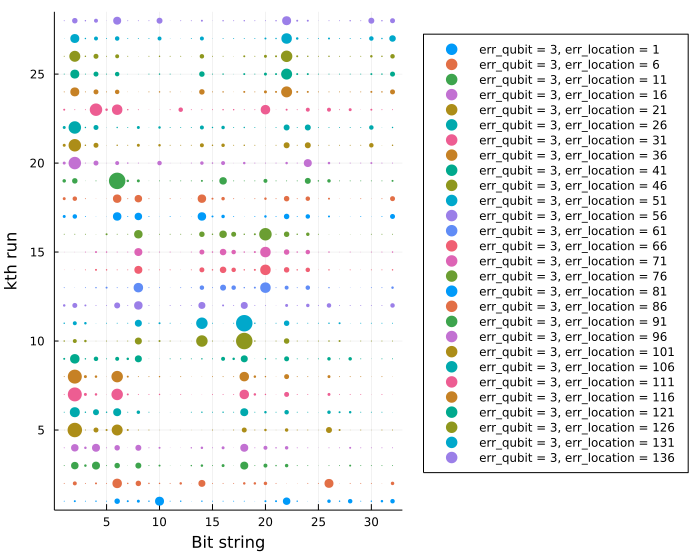

In [299]:
N=5
depth = 20
s = siteinds("Qubit", N)

# choose a random location among all operations  
bit_flip_location_list = [i for i in 1:5:floor(Int, N*depth + depth/2*(N-1))];
max_k = length(bit_flip_location_list);
bit_flip_qubit_list = [3 for i in 1:max_k];

k=1
bit_flip_qubit = bit_flip_qubit_list[k]
bit_flip_location = bit_flip_location_list[k]
psi= run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location);
squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
Plots.scatter([j for j in 1:2^N], ones(2^N)*k, 
    markersize=squared_mag*40,markercolor	=k,markerstrokecolor=k,
    ylims=(0.5, 1.5), axis=true, ticks = true, size = (500, 800), 
    legend=true, label = "err_qubit = $bit_flip_qubit, err_location = $bit_flip_location", )

for k in 2:max_k
    bit_flip_qubit = bit_flip_qubit_list[k]
    bit_flip_location = bit_flip_location_list[k]
    
    psi = run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location);
    squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
       
    Plots.scatter!([j for j in 1:2^N], ones(2^N)*k, 
        markersize=squared_mag*40,markercolor=k,markerstrokecolor=k,
        ylims=(0.5, max_k+0.5), axis=true, ticks = true, size = (700, 20*max_k), 
        label = "err_qubit = $bit_flip_qubit, err_location = $bit_flip_location", legend=:outerright)
end

ylabel!("kth run")
xlabel!("Bit string")
current()

### Bit-flip error on different qubits at a fixed location
Here, we fix the error location and vary error qubit.

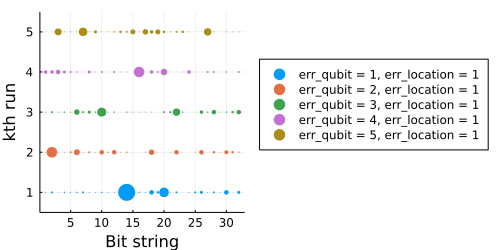

In [298]:
N=5
depth = 20
s = siteinds("Qubit", N)

# choose a random location among all operations  
max_k = N;bit_flip_location_list = [1 for i in 1:max_k];
bit_flip_qubit_list = [i for i in 1:max_k];

k=1
bit_flip_qubit = bit_flip_qubit_list[k]
bit_flip_location = bit_flip_location_list[k]
psi= run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location);
squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
Plots.scatter([j for j in 1:2^N], ones(2^N)*k, 
    markersize=squared_mag*40,markercolor	=k,markerstrokecolor=k,
    ylims=(0.5, 1.5), axis=true, ticks = true, size = (500, 800), 
    legend=true, label = "err_qubit = $bit_flip_qubit, err_location = $bit_flip_location", )

for k in 2:max_k
    bit_flip_qubit = bit_flip_qubit_list[k]
    bit_flip_location = bit_flip_location_list[k]
    
    psi = run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location);
    squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
    
    Plots.scatter!([j for j in 1:2^N], ones(2^N)*k, 
        markersize=squared_mag*40,markercolor=k,markerstrokecolor=k,
        ylims=(0.5, max_k+0.5), axis=true, ticks = true, size = (500, 50*max_k), 
        label = "err_qubit = $bit_flip_qubit, err_location = $bit_flip_location", legend=:outerright)
end

ylabel!("kth run")
xlabel!("Bit string")
current()

# Task 3 
## Exploring convergence of the Porter-Thomas Distribution.

As the random circuit gets sufficiently deep, the probability distribution (from an ideal circuit with no error) converges to the Porter-Thomas distribution. Its probability density function (PDF) is $2^N \exp(2^Np)$, where $p$ is the probability of measuring a random bit string. Its cumulative density function (CDF) is $1-\exp(2^Np)$. We plot the CDF of simulated distributions on a 8-qubit circuit and show its convergence to the Porter-Thomas distribution when the circuit depth is >64.

In [302]:
N=8 # 8 qubits
s = siteinds("Qubit", N)

# Calculate the probability distribution with depth = 1
psi = run(N, 1);
squared_mag_list = [[abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]];

# Calculate the probability distribution with depth > 1
depth_list = [2^3, 2^6, 2^9];

for depth in depth_list
    psi = run(N, depth);
    squared_mag_list = append!(squared_mag_list, 
        [[abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]]);
end

# Sort all the probability lists in order to get the CDF
for i in 1:4
    squared_mag_list[i] = sort(squared_mag_list[i])
    # Add [1,1] to complete the full CDF curve
    squared_mag_list[i] = append!(squared_mag_list[i], [1])
end

CDF = [i/(2^N) for i in 1:2^N];
CDF = append!(CDF, [1]);
depth_list = append!([1], depth_list); # Add depth=1 to the list

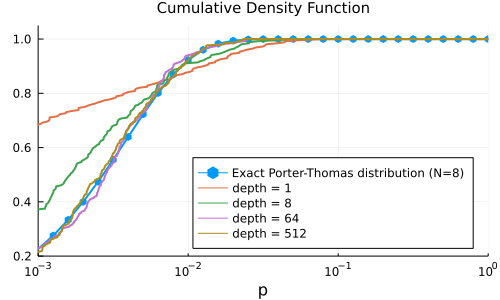

In [307]:
# Exact Porter-Thomas distribution
px = [10^(x) for x in -3:0.1:0]
py = [1-exp(-2^N*p) for p in px]
Plots.plot(px, py,  markershape = :hexagon, linewidth = 2,xaxis=:log, xlims=(0.001, 1), ylims=(0.2, 1.05), 
    markercolor=1,markerstrokecolor=1, label = "Exact Porter-Thomas distribution (N=$N)", 
    title = "Cumulative Density Function", titlefont=font(10))

for i in 1:4
    depth = depth_list[i]
    Plots.plot!(squared_mag_list[i], CDF, legend=:bottomright, linewidth = 2, label = "depth = $depth", 
    size = (500,300))
end

xlabel!("p")

# Task 4
## Exploring the effect of 2-qubit gate errors.
Here we calculate the linear cross-entropy fidelity $F_{XEB}$ when sampling from a noisy circuit. The noise is a fixed angle error on each 2-qubit gate. $F_{XEB}$ is expected to drop as the angle error increases.

In [132]:
function run_with_angle_error(N, depth, angle_err=0, random_seed = 1234)
    # Random circuit.
    gates = Vector{Tuple}[]
    
    Random.seed!(random_seed) # Set the random seed to fix the random circuit

    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1
        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*(rand()+angle_err),)) # fixed angle error on each 2-qubit gate
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end
    
    # returns the value of the last expression evaluated
    psi = runcircuit(N, gates)
end

run_with_angle_error (generic function with 5 methods)

In [370]:
N=8; # Number of qubits
s = siteinds("Qubit", N);
depth = 220;

In [371]:
true_psi = run_with_angle_error(N, depth, 0);
true_prob = [abs(inner(true_psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N];

# uniform_prob = ones(2^N)/2^N
XEB = [2^N*(true_prob'true_prob)-1]

1-element Vector{Float64}:
 0.9939071701386883

##### Linear Scale Plot

In [372]:
# Computing the true probability distribution without angle error
true_psi = run_with_angle_error(N, depth, 0);
true_prob = [abs(inner(true_psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N];

# uniform_prob = ones(2^N)/2^N
XEB = [2^N*(true_prob'true_prob)-1]

step = 0.02
angle_err_list = [i for i in step:step:1]

for angle_err in angle_err_list
    err_psi = run_with_angle_error(N, depth, angle_err);
    err_prob = [abs(inner(err_psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N];
    XEB = append!(XEB, [2^N*(true_prob'err_prob)-1]);
    print(length(XEB)) # just to check the program is indeed running
end

angle_err_list = append!([0.0], angle_err_list); # Add zero angle error to the beginning of the list

23456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051

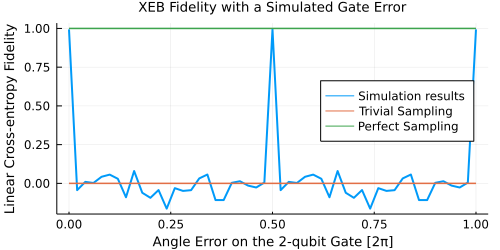

In [373]:
Plots.plot(angle_err_list, XEB, linewidth = 2, size = (500,250), 
    title="XEB Fidelity with a Simulated Gate Error", label = "Simulation results",
    legend=:right, guidefont=font(9), titlefont=font(9))
Plots.plot!(angle_err_list, zeros(length(angle_err_list)),linewidth = 1.5, label = "Trivial Sampling")
Plots.plot!(angle_err_list, ones(length(angle_err_list)),linewidth = 1.5, label = "Perfect Sampling")
xlabel!("Angle Error on the 2-qubit Gate [2$pi]")
ylabel!("Linear Cross-entropy Fidelity")

The $F_{XEB}$ shows a **very rapid** drop as soon as the error deviates from 0. The log-scale plot zooms in on the range near zero. At angle error = $\pi$ or $2\pi$, there is effectively no error on the gate.

##### Log Scale Plot

In [374]:
# Compute the true probability distribution without angle error
true_psi = run_with_angle_error(N, depth, 0);
true_prob = [abs(inner(true_psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N];

# uniform_prob = ones(2^N)/2^N
XEB = [2^N*(true_prob'true_prob)-1]

angle_err_list = [10^(x) for x in -4:0.1:-0.5]

for angle_err in angle_err_list
    err_psi = run_with_angle_error(N, depth, angle_err);
    err_prob = [abs(inner(err_psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N];
    XEB = append!(XEB, [2^N*(true_prob'err_prob)-1]);
    print(length(XEB)) # just to make sure the program is indeed running when waiting for the for loop to finish
end

angle_err_list = append!([0.0], angle_err_list); # Add zero angle error to the beginning of the list

2345678910111213141516171819202122232425262728293031323334353637

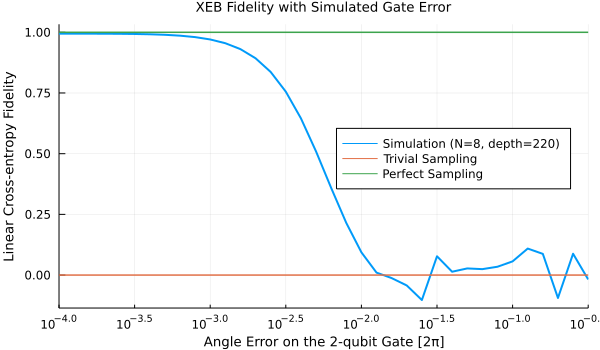

In [375]:
Plots.plot(angle_err_list, XEB, linewidth = 2, size = (600,350), 
    title="XEB Fidelity with Simulated Gate Error", label = "Simulation (N=$N, depth=$depth)",
    legend=:right, guidefont=font(9), titlefont=font(9), xaxis=:log, xlims=(10^(-4), 10^(-0.5)))
Plots.plot!(angle_err_list, zeros(length(angle_err_list)),linewidth = 1.5, label = "Trivial Sampling")
Plots.plot!(angle_err_list, ones(length(angle_err_list)),linewidth = 1.5, label = "Perfect Sampling")
xlabel!("Angle Error on the 2-qubit Gate [2$pi]")
ylabel!("Linear Cross-entropy Fidelity")

For sanity check, we plot the true probability distribution versus the exact Porter-Thomas Distribution. The agreement between the two curves indicates that our circuit is deep enough and our results above are valid.

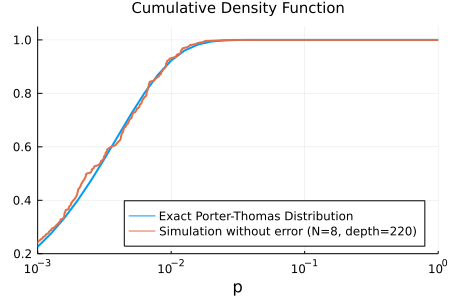

In [378]:
sort_true_prob = sort(true_prob)
sort_true_prob = append!(sort_true_prob, [1])
CDF = [i/(2^N) for i in 1:2^N];
CDF = append!(CDF, [1]);
Plots.plot(px, py, linewidth = 2, label = "Exact Porter-Thomas Distribution")
Plots.plot!(sort_true_prob,CDF, xaxis=:log, xlims=(0.001, 1), ylims=(0.2, 1.05),
    linewidth = 2, label="Simulation without error (N=$N, depth=$depth)", size = (450,300),
    legend=:bottomright, title = "Cumulative Density Function", titlefont=font(10))
xlabel!("p")

# Art Generation for Fun: Pollock Paiting

We use the speckle patterns to generate Pollock paintings :). It seems that with shallow depth, the resulting painting is clustered, while as the circuit gets deep, the speckles distribution is more scattered.

In [465]:
function art_generation(N, depth, random_seed1=100, random_seed2=1111)

    Random.seed!(random_seed1)

    s = siteinds("Qubit", N)
    max_k = 16


    # choose a random location among all operations  
    bit_flip_qubit_list = [rand(1:N) for i in 1:max_k];
    bit_flip_location_list = [rand(1: floor(Int, N*depth + depth/2*(N-1))) for i in 1:max_k];
    color_list = [rand(1:max_k) for i in 1:max_k]
    shapes = Plots.supported_markers();
    shape_list = [rand(1:max_k) for i in 1:max_k]

    k=1
    bit_flip_qubit = bit_flip_qubit_list[k]
    bit_flip_location = bit_flip_location_list[k]
    psi= run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location, random_seed2);
    squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]
    Plots.scatter([j for j in 1:2^N], ones(2^N)*k, 
        markersize=squared_mag*40,markercolor=rand(1:max_k),markerstrokecolor=rand(1:max_k),
        ylims=(0.5, 1.5), axis=true, ticks = true, size = (500, 800), 
        legend=true, label = "err_qubit = $bit_flip_qubit, err_location = $bit_flip_location", )

    for k in 2:max_k
        bit_flip_qubit = bit_flip_qubit_list[k]
        bit_flip_location = bit_flip_location_list[k]

        psi = run_with_bit_flip_error(N, depth, bit_flip_qubit, bit_flip_location);
        squared_mag = [abs(inner(psi, productMPS(s, split(string(i-1, base = 2, pad = N),""))))^2 for i in 1:2^N]


        Plots.scatter!([j for j in 1:2^N], ones(2^N)*k, markershape = shapes[shape_list[k]],
            markersize=squared_mag*100,markercolor=color_list[k],markerstrokecolor=color_list[k],
            ylims=(1, max_k+0.5), axis=false, ticks = false, size = (190, 12*max_k), guidefont=font(9), legend=false)
    end
end

art_generation (generic function with 3 methods)

Generated from 4 qubits and the circuit depth is 2.

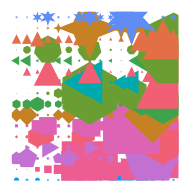

In [466]:
art_generation(4, 2) 
current()

Generated from 4 qubits and the circuit depth is 3.

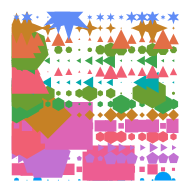

In [467]:
art_generation(4, 3)
current()

Generated from 4 qubits and the circuit depth is 100.

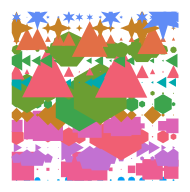

In [469]:
art_generation(4, 100)
current()